<a href="https://colab.research.google.com/github/charlieh0tel/ddf_analysis/blob/main/DopplerAnalysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
%pip install quantities
import numpy as np
import quantities as pq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import shutil
import tempfile
import urllib
import scipy.io.wavfile

def ReadWAVFromURL(url):
  with urllib.request.urlopen(url) as response:
    with tempfile.NamedTemporaryFile(delete=True) as tmp_file:
      shutil.copyfileobj(response, tmp_file)
      return scipy.io.wavfile.read(tmp_file.name)

In [47]:
n_antennas = 4
dwell_time = 156. * pq.us
rotation_period = n_antennas * dwell_time
rotation_frequency = (1. / rotation_period).rescale(pq.kHz)
print(f"{rotation_period:f} = {rotation_frequency:f}")

624.000000 us = 1.602564 kHz


In [48]:
URL = 'https://github.com/charlieh0tel/ddf_analysis/raw/main/Wouxun_KG-UV3D_10ft_away_16kbps_stereo_440.800_test3.wav'

sample_rate, samples = ReadWAVFromURL(URL)

left = samples[:, 0]
right = samples[:, 1]
print(f"sample_rate={sample_rate} [Hz], samples={len(samples)}, time={len(samples) / sample_rate} [s]")
print(f"samples={samples}")
print(f"left={left}")
print(f"right={right}")

sample_rate=48000 [Hz], samples=2035215, time=42.4003125 [s]
samples=[[19048 -1981]
 [20507 -2275]
 [21315 -1381]
 ...
 [12289 -2395]
 [ 8895 -1226]
 [ 5144 -2803]]
left=[19048 20507 21315 ... 12289  8895  5144]
right=[-1981 -2275 -1381 ... -2395 -1226 -2803]


In [49]:
# Start later in the file
time_offset = 35.
start = int(time_offset * sample_rate)
left = left[start:]
right = right[start:]

In [50]:
def plot_audio(time_sec,n_samples,signal,filtered=None, skip=0):
  signal = signal[skip:]
  if filtered is not None: filtered = filtered[skip:]
  plt.figure()
  plt.subplot(1, 1, 1)
  plt.xlabel('Time (msec)')
  plt.grid()
  plt.plot(time_sec[:n_samples]*1000,signal[:n_samples],'y-',label='Audio signal')
  if filtered is not None:
    plt.plot(time_sec[:n_samples]*1000,filtered[:n_samples],'g-',label='Filtered signal')
  plt.legend()

720


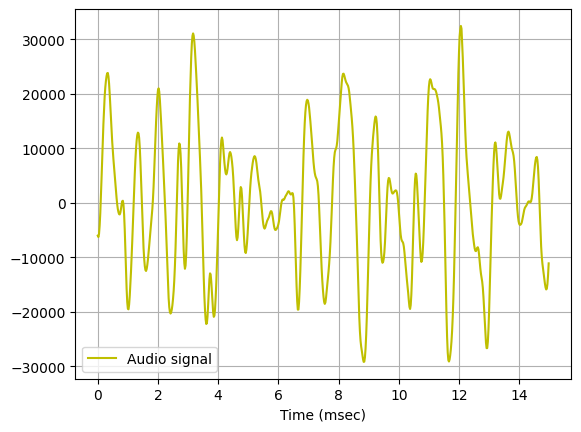

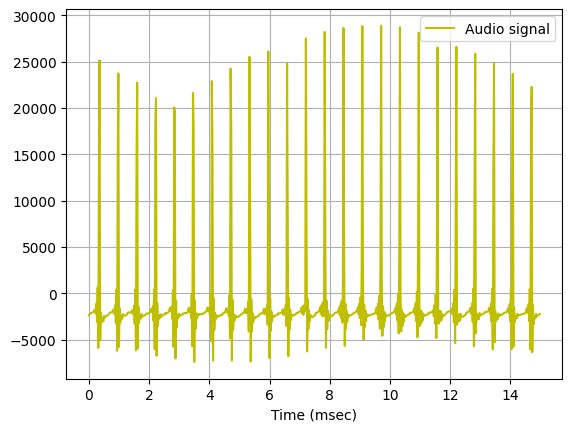

In [51]:
T = 15e-3
n = int(T * sample_rate)
print(n)
tvec = np.linspace(0, T, n, endpoint=False)
plot_audio(tvec, n, left)
plot_audio(tvec, n, right)

In [52]:
from scipy.signal import lfiltic, lfilter, firwin

class fir_filter(object):
  def __init__(self, coeffs):
    self.coeffs = coeffs
    self.zl = lfiltic(self.coeffs, 32768.0, [], [])
  def __call__(self, data):
    result, self.zl = lfilter(self.coeffs, 32768.0, data, -1, self.zl)
    return result
  def __len__(self):
      return len(self.coeffs)

class bpf_filter(fir_filter):
  def __init__(self, sample_rate, ntaps, f_center, width):
    half_width = width / 2.
    f_low = f_center - half_width
    f_high = f_center + half_width
    coeffs = np.array(
        firwin(ntaps, [f_low / (sample_rate / 2), f_high / (sample_rate / 2)],
        width = None, pass_zero = False, scale = True, window='hann') * 32768, dtype=int)
    super(bpf_filter, self).__init__(coeffs)

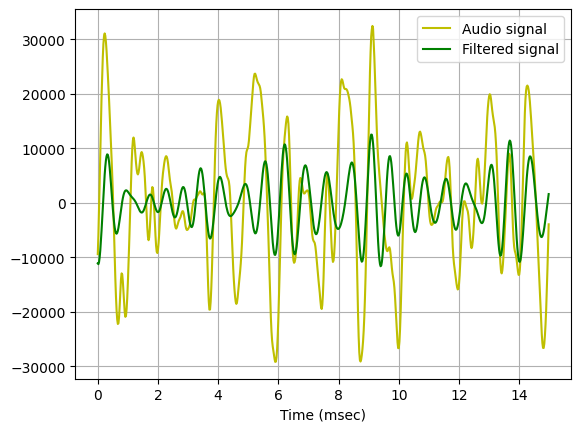

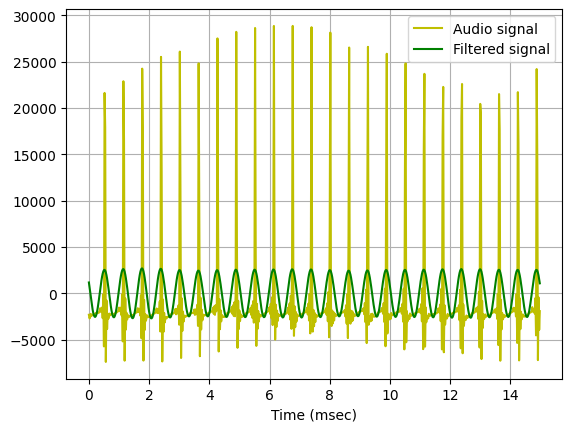

In [53]:
fcenter = rotation_frequency.rescale(pq.Hz).magnitude
width = 1.0  
ntaps = 141
bpf = bpf_filter(sample_rate, ntaps, fcenter, width)

filter_delay = ntaps // 2
left_filtered = bpf(left)[filter_delay:]
right_filtered = bpf(right)[filter_delay:]

plot_audio(tvec, n, left, left_filtered, skip=ntaps)
plot_audio(tvec, n, right, right_filtered, skip=ntaps)

In [56]:
def naive_normalize(v):
  return (v - v.mean()) / v.std()

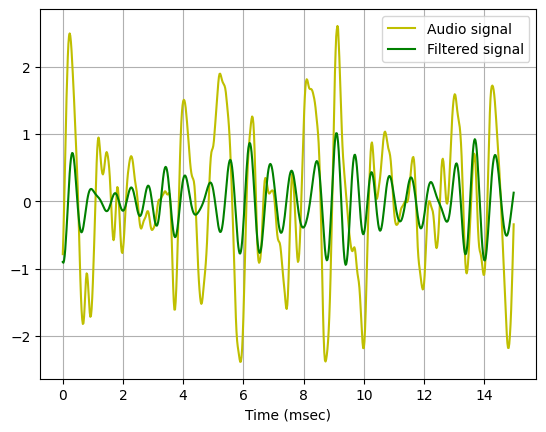

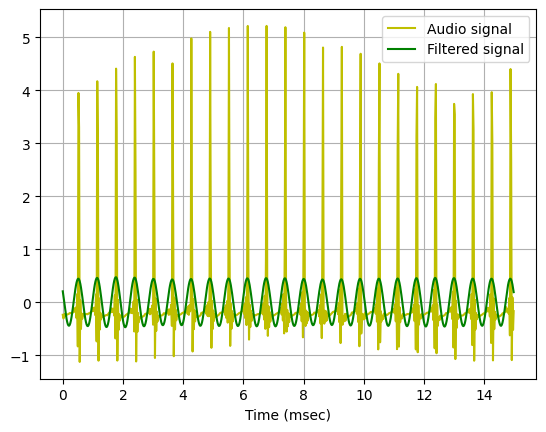

In [57]:
left_norm = naive_normalize(left)
right_norm = naive_normalize(right)

left_norm_filtered = bpf(left_norm)[filter_delay:]
right_norm_filtered = bpf(right_norm)[filter_delay:]

plot_audio(tvec, n, left_norm[shift:], left_norm_filtered[shift:])
plot_audio(tvec, n, right_norm[shift:], right_norm_filtered[shift:])